In [1]:
import matplotlib.pyplot as plt
from sklearn.datasets import make_regression as MR
from sklearn.linear_model import LinearRegression as LR
import statsmodels.api as sm 
import numpy as np
import pandas as pd
import sklearn
import matplotlib.pyplot as plt

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import Lasso as LLR
import statsmodels.api as sm 
from sklearn.datasets import make_sparse_uncorrelated
import matplotlib.pyplot as plt
import numpy as np
import statsmodels.api as sm 

In [2]:
from sklearn import datasets
from sklearn.linear_model import Lasso
from random import shuffle
wine = datasets.load_wine()

In [3]:
X=wine['data']
Y=wine['target']

In [4]:
XY=list(zip(X,Y))
shuffle(XY)
X,Y=list(zip(*XY))
X=np.array(X)
Y=np.array(Y)

In [5]:
alphas = [np.e**(x/10) for x in range(-100,-30)]
Scores=[]
for alpha in alphas:
    log_reg = LLR(alpha)
    kfold = KFold(n_splits=10)
    score = cross_val_score(log_reg, X[:100], Y[:100], cv = kfold)
    Scores.append(np.mean(score))
    print("alpha: %s, CV Score Avg: %s " % (alpha, np.mean(score)))

alpha: 4.5399929762484875e-05, CV Score Avg: 0.866255980075173 
alpha: 5.017468205617531e-05, CV Score Avg: 0.8662555221870356 
alpha: 5.545159943217697e-05, CV Score Avg: 0.866254764110684 
alpha: 6.128349505322217e-05, CV Score Avg: 0.8662540282044471 
alpha: 6.772873649085393e-05, CV Score Avg: 0.8662530014243867 
alpha: 7.485182988770063e-05, CV Score Avg: 0.8662519023367589 
alpha: 8.272406555663227e-05, CV Score Avg: 0.8662506798492181 
alpha: 9.142423147817332e-05, CV Score Avg: 0.8662490029304968 
alpha: 0.00010103940183709347, CV Score Avg: 0.8662470910075403 
alpha: 0.00011166580849011483, CV Score Avg: 0.8662451499395504 
alpha: 0.00012340980408667962, CV Score Avg: 0.8662425672378937 
alpha: 0.00013638892648201145, CV Score Avg: 0.866239506177257 
alpha: 0.00015073307509547656, CV Score Avg: 0.8662361598783892 
alpha: 0.0001665858109876336, CV Score Avg: 0.8662316448206863 
alpha: 0.00018410579366757928, CV Score Avg: 0.8662244285809342 
alpha: 0.00020346836901064428, CV Sc

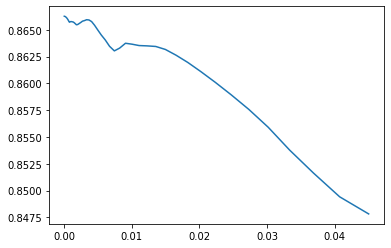

In [6]:
plt.plot(alphas,Scores)

In [7]:
alpha=alphas[np.argmax(Scores)] # best alpha

model=LLR(alpha).fit(X[:100], Y[:100])
Coef=model.coef_

In [8]:
rearange=Coef.argsort()
Coef.sort()
Coef[:5]=40
Coef[5:]=25

In [9]:
X=X[:,rearange[::-1]]
Coef.sort()
Coef=Coef[::-1]
font_size=Coef.astype(int)
grid=list(zip([0]*5+[145]*8,list(range(2,252,50))+list(range(2,252,32))))

In [10]:
from PIL import Image, ImageDraw, ImageFont
from tqdm import tqdm
import numpy as np
from matplotlib import pyplot as plt


def sampletoimage(sample):
 img =  Image.fromarray(np.zeros((255,255)).astype('uint8'))
 draw = ImageDraw.Draw(img)    
 for f,s,g in zip(font_size,sample,grid):
  font = ImageFont.truetype("./LiberationMono-Bold.ttf", size=f)
  draw.text(g,str(s),font=font, fill='white')

 return [np.array(img) for _ in range(3)]

In [11]:
X=np.array(list(map(sampletoimage,X)))

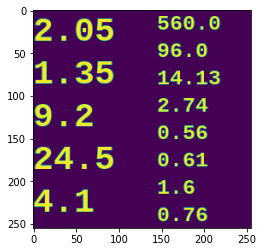

In [12]:
plt.imshow(X[3,0])

### ResNet18

In [13]:
import torch.nn as nn
from torchvision import models

def resnet18update(net, only_last = True):
   if only_last:
      for name, param in net.named_parameters():
        if 'fc' not in name and 'act' not in name: param.requires_grad = False  # freezing all except classifier
      for name, param in net.layer4[1].named_parameters():
        param.requires_grad = True   # unfreezing last sub-block
   else:
      for name, param in net.named_parameters():
          if 'layer4' not in name:
              param.requires_grad = False
          else:
              break
   for name, param in net.named_parameters():
        if param.requires_grad: print(name)

In [14]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F 
import numpy as np
import torchvision
from torchvision import *

def accuracy(out, labels):
    _,pred = torch.max(out, dim=1)
    return torch.sum(pred==labels).item()

## Train Validation Test

In [15]:
def accuracy(pred,y):
    return sum(pred==y)/len(y)
from sklearn.metrics import precision_recall_curve, f1_score, auc, precision_score, recall_score, roc_auc_score, roc_curve
import matplotlib.pyplot as plt
import pandas as pd
from statistics import mean
from sklearn.model_selection import KFold, train_test_split
torch.manual_seed(0)
Train_stats=[]
Test_stats=[]
device='cuda:0'

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=10, shuffle=True)
if(True):
 train_data = torch.utils.data.DataLoader(list(zip(X_train,Y_train)), batch_size=32, shuffle=True, drop_last=True,num_workers=2)
 validation_data = torch.utils.data.DataLoader(list(zip(X_test,Y_test)),batch_size=1,num_workers=2) 

 net = models.resnet18(pretrained=True)
 num_features = net.fc.in_features
 net.fc= nn.Linear(num_features, 3)            
 resnet18update(net)
 net = nn.Sequential(net, nn.Softmax(1)) 
 net=net.to(device)
 #loss and optim
 criterion = nn.CrossEntropyLoss()
 optimizer = optim.SGD(net.parameters(), lr=0.01, momentum=0.9)
 
 for epoch in range(30):
   
    
    Names=['Epoch','Accuracy','Loss']
    
    Stats={}
    
    Stats['Accuracy']=0
    
    if(True):
     Stats=[]
     for i, (inputs, labels) in enumerate(train_data):
        net.train()
        inputs = inputs.to(device, dtype=torch.float); 
        optimizer.zero_grad()
        outputs = net(inputs)
        labels=labels.to(device).long()
        loss = criterion(outputs,labels)
        loss.backward()
        optimizer.step()

        average='micro'
        _,pred = torch.max(outputs, dim=1)
        Stats.append([epoch+1,accuracy(pred,labels).item(),loss.item()])
     Stats={key:val for key,val in zip(Names,np.mean(np.asarray(Stats).T,axis=1))}
    
    Train_stats.append(Stats)
    print("-----      TRAIN RESULTS      -----")
    print(Train_stats[-1])
 
    Stats=[]

    for i, (inputs, labels) in enumerate(validation_data):
        net.eval()
        inputs = inputs.to(device, dtype=torch.float); 
        outputs = net(inputs)
        labels=labels.to(device).long()
        loss = criterion(outputs,labels)

        _,pred = torch.max(outputs, dim=1)
        Stats.append([epoch+1,accuracy(pred,labels).item(),loss.item()])
    
    Test_stats.append({key:val for key,val in zip(Names,np.mean(np.asarray(Stats).T,axis=1))})
    print("-----      TEST  RESULTS     -----")
    print(Test_stats[-1])
 

layer4.1.conv1.weight
layer4.1.bn1.weight
layer4.1.bn1.bias
layer4.1.conv2.weight
layer4.1.bn2.weight
layer4.1.bn2.bias
fc.weight
fc.bias
-----      TRAIN RESULTS      -----
{'Epoch': 1.0, 'Accuracy': 0.2890625, 'Loss': 1.1301480829715729}
-----      TEST  RESULTS     -----
{'Epoch': 1.0, 'Accuracy': 0.4722222222222222, 'Loss': 1.077694962422053}
-----      TRAIN RESULTS      -----
{'Epoch': 2.0, 'Accuracy': 0.390625, 'Loss': 1.0853267014026642}
-----      TEST  RESULTS     -----
{'Epoch': 2.0, 'Accuracy': 0.4722222222222222, 'Loss': 1.03043412996663}
-----      TRAIN RESULTS      -----
{'Epoch': 3.0, 'Accuracy': 0.5234375, 'Loss': 1.0432239472866058}
-----      TEST  RESULTS     -----
{'Epoch': 3.0, 'Accuracy': 0.6111111111111112, 'Loss': 1.0029115974903107}
-----      TRAIN RESULTS      -----
{'Epoch': 4.0, 'Accuracy': 0.6015625, 'Loss': 0.9642079174518585}
-----      TEST  RESULTS     -----
{'Epoch': 4.0, 'Accuracy': 0.5833333333333334, 'Loss': 0.9705619348420037}
-----      TRAIN R

In [16]:
Test=pd.DataFrame(Test_stats)
Train=pd.DataFrame(Train_stats)

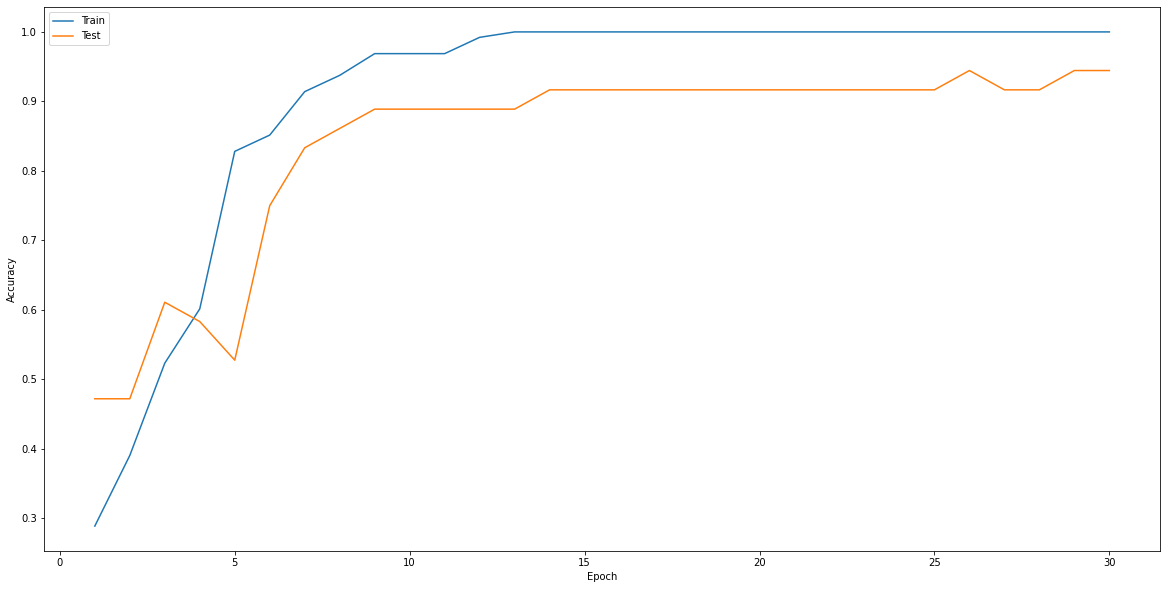

In [18]:
ax=Train.plot(x='Epoch',y='Accuracy',label='Train',figsize=(20,10))
Test.plot(x='Epoch',y='Accuracy',ax=ax,label='Test')
ax.set_ylabel('Accuracy')
a=1

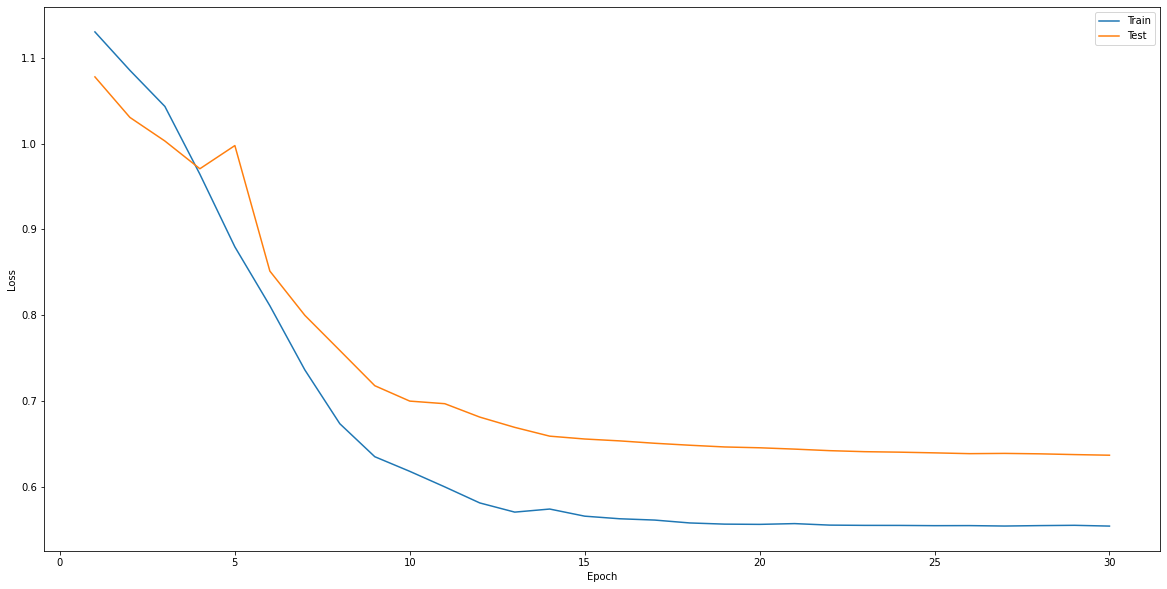

In [19]:
ax=Train.plot(x='Epoch',y='Loss',label='Train',figsize=(20,10))
Test.plot(x='Epoch',y='Loss',ax=ax,label='Test')
ax.set_ylabel('Loss')
a=1